Keras-GAN (Keras implementations of Generative Adversarial Networks)
https://github.com/eriklindernoren/Keras-GAN
をColabに移植したものです。
そのままで１部動かない部分があるため修正を加えています。
修正に関してはコードのコメントにあります。

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_201 (Conv2D)          (None, 14, 14, 16)        160       
_________________________________________________________________
leaky_re_lu_117 (LeakyReLU)  (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_117 (Dropout)        (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_202 (Conv2D)          (None, 7, 7, 32)          4640      
_________________________________________________________________
zero_padding2d_30 (ZeroPaddi (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_144 (Bat (None, 8, 8, 32)          128       
_________________________________________________________________
leaky_re_lu_118 (LeakyReLU)  (None, 8, 8, 32)          0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.999918] [G loss: 1.000184]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


100 [D loss: 0.999966] [G loss: 1.000119]
200 [D loss: 0.999969] [G loss: 1.000061]
300 [D loss: 0.999972] [G loss: 1.000070]
400 [D loss: 0.999974] [G loss: 1.000057]
500 [D loss: 0.999969] [G loss: 1.000067]
600 [D loss: 0.999974] [G loss: 1.000067]
700 [D loss: 0.999965] [G loss: 1.000063]
800 [D loss: 0.999965] [G loss: 1.000063]
900 [D loss: 0.999965] [G loss: 1.000067]
1000 [D loss: 0.999967] [G loss: 1.000054]
1100 [D loss: 0.999962] [G loss: 1.000068]
1200 [D loss: 0.999973] [G loss: 1.000060]
1300 [D loss: 0.999967] [G loss: 1.000063]
1400 [D loss: 0.999978] [G loss: 1.000056]
1500 [D loss: 0.999974] [G loss: 1.000063]
1600 [D loss: 0.999972] [G loss: 1.000066]
1700 [D loss: 0.999971] [G loss: 1.000071]
1800 [D loss: 0.999976] [G loss: 1.000038]
1900 [D loss: 0.999970] [G loss: 1.000057]


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


2000 [D loss: 0.999975] [G loss: 1.000061]
2100 [D loss: 0.999973] [G loss: 1.000035]
2200 [D loss: 0.999978] [G loss: 1.000061]
2300 [D loss: 0.999974] [G loss: 1.000073]
2400 [D loss: 0.999970] [G loss: 1.000061]
2500 [D loss: 0.999977] [G loss: 1.000066]
2600 [D loss: 0.999982] [G loss: 1.000059]
2700 [D loss: 0.999966] [G loss: 1.000056]
2800 [D loss: 0.999982] [G loss: 1.000050]
2900 [D loss: 0.999970] [G loss: 1.000046]
3000 [D loss: 0.999970] [G loss: 1.000070]
3100 [D loss: 0.999971] [G loss: 1.000051]
3200 [D loss: 0.999969] [G loss: 1.000049]
3300 [D loss: 0.999980] [G loss: 1.000058]
3400 [D loss: 0.999964] [G loss: 1.000061]
3500 [D loss: 0.999962] [G loss: 1.000064]
3600 [D loss: 0.999972] [G loss: 1.000052]
3700 [D loss: 0.999966] [G loss: 1.000061]
3800 [D loss: 0.999981] [G loss: 1.000064]
3900 [D loss: 0.999969] [G loss: 1.000056]


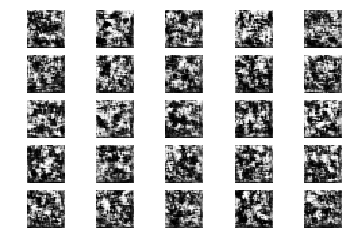

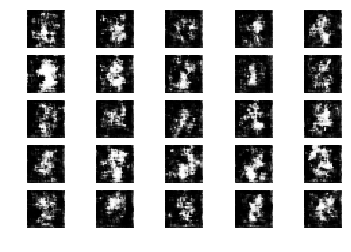

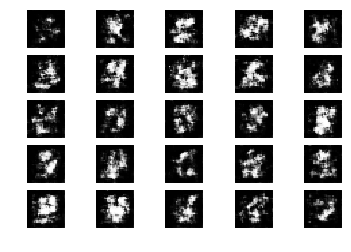

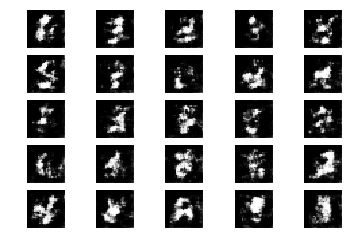

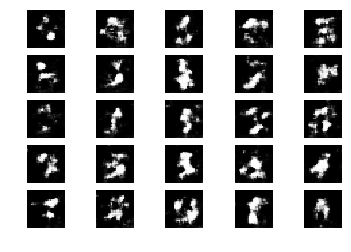

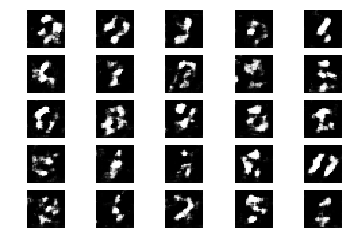

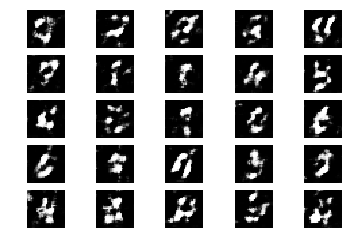

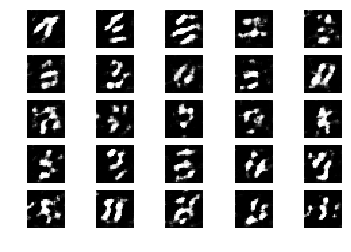

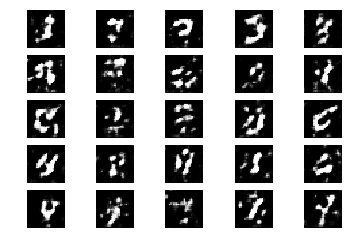

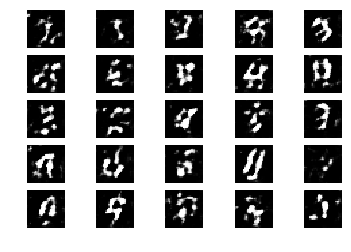

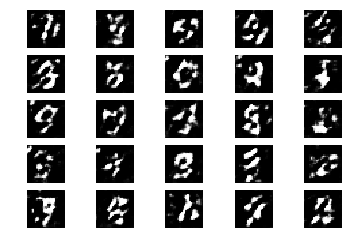

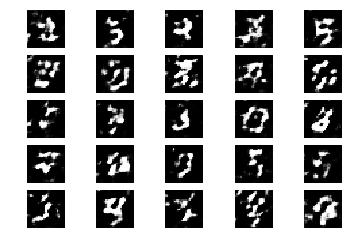

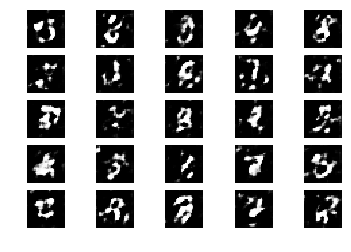

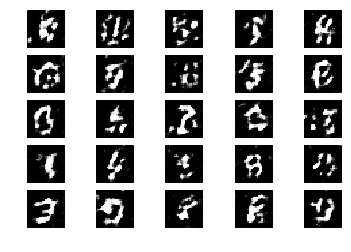

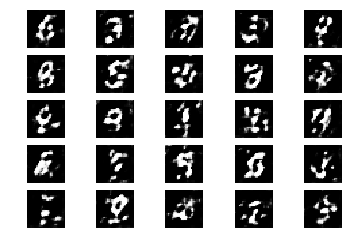

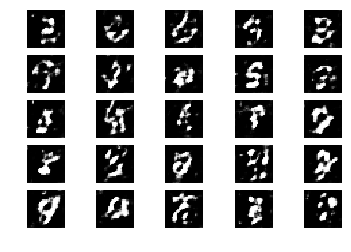

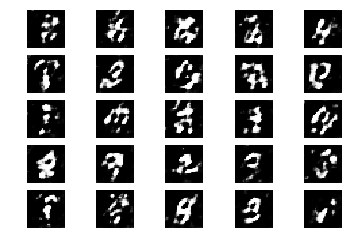

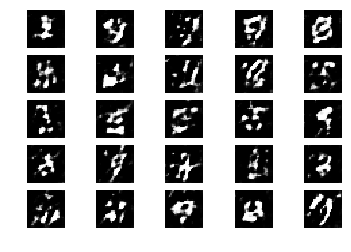

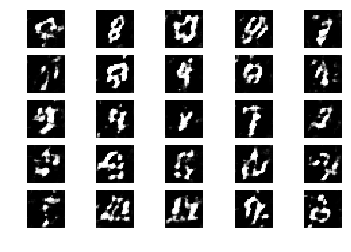

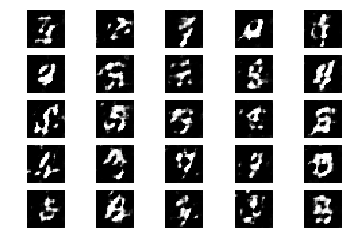

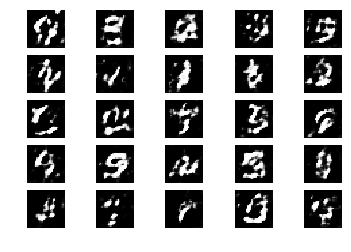

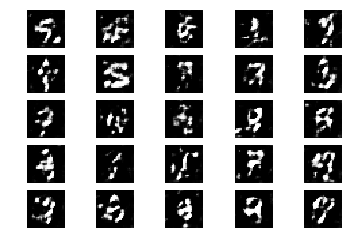

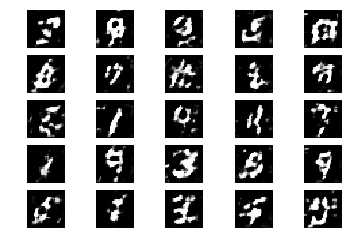

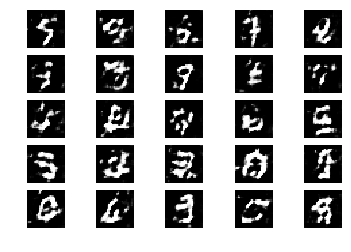

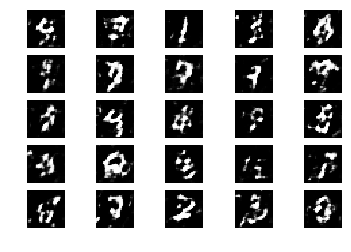

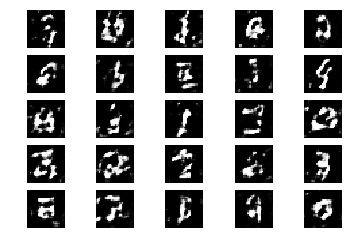

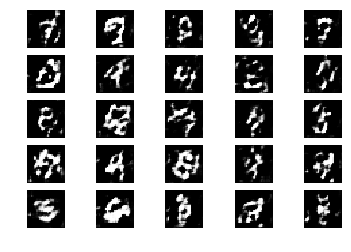

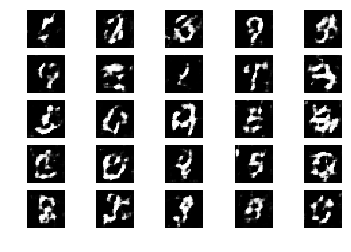

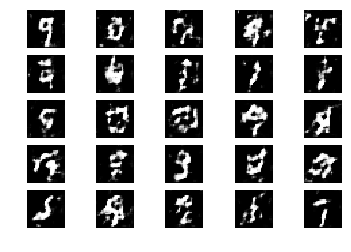

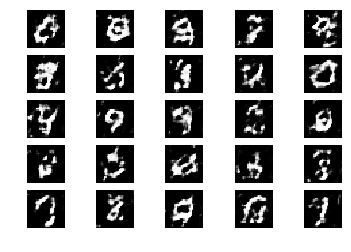

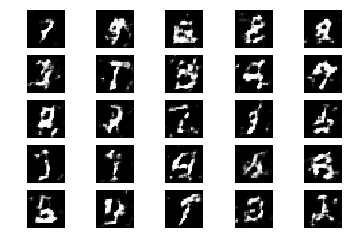

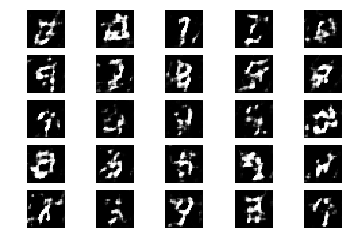

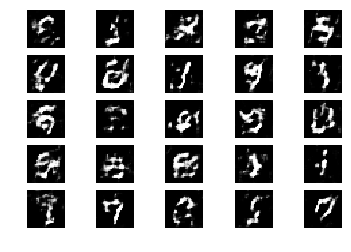

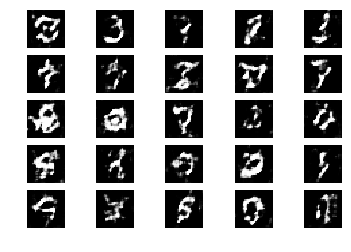

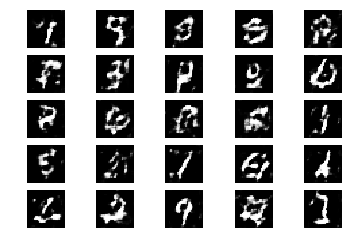

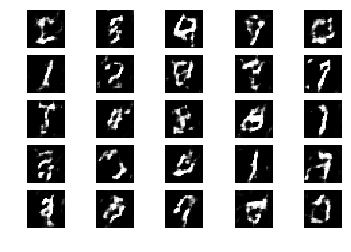

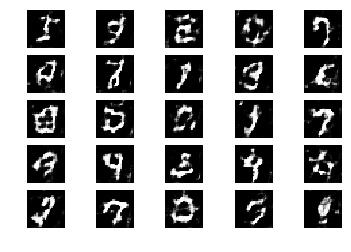

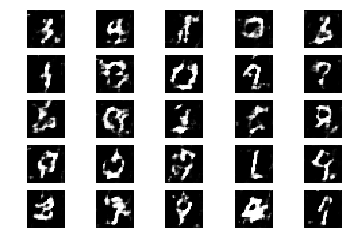

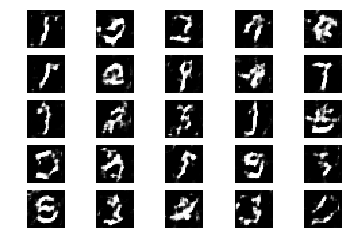

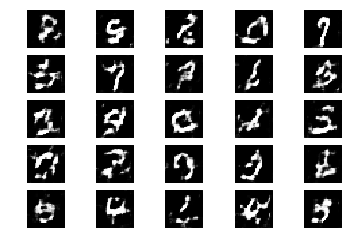

In [42]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

import keras.backend as K

import matplotlib.pyplot as plt

import sys

import numpy as np

class WGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        self.clip_value = 0.01
        optimizer = RMSprop(lr=0.00005)

        # Build and compile the critic
        self.critic = self.build_critic()
        self.critic.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.critic.trainable = False

        # The critic takes generated images as input and determines validity
        valid = self.critic(img)

        # The combined model  (stacked generator and critic)
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])
        
    #Wasserstain lossは  E[f(x_{real})]-E[f(x_fake)]なので
    #y_real=+1, y_fake=-1とすれば 
    #xの予測結果y_pred(x)=f(x)とxの真のラベルy_trueの積
    #y_true*y_pred(x)=y_true*f(x)の(x,y_true)に関する期待値で書ける
    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=4, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_critic(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake = np.ones((batch_size, 1))

        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                
                # Sample noise as generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Generate a batch of new images
                gen_imgs = self.generator.predict(noise)

                # Train the critic
                d_loss_real = self.critic.train_on_batch(imgs, valid)
                d_loss_fake = self.critic.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

                # Clip critic weights
                for l in self.critic.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)


            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(noise, valid)



            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
                # Plot the progress インターバルごとに出力するように修正
                print ("%d [D loss: %f] [G loss: %f]" % (epoch, 1 - d_loss[0], 1 - g_loss[0]))
                
    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #以下でColabで保存しようとすると動かないので適宜場所の修正が必要        
        #fig.savefig("images/mnist_%d.png" % epoch)
        #plt.close()


if __name__ == '__main__':
    wgan = WGAN()
    wgan.train(epochs=4000, batch_size=32, sample_interval=100)